# LDDMM: how To Bring Deformations from Subject-Specific Atlases Into the Tangent Space at the Global Atlas

- Load meshes:
  - Use DenseMaternalMeshLoader to load left hippocampus structure for all three subjects

- Create subject-specific pre-pregnancy atlases:
  - For each subject i:
    - Get pre-pregnancy meshes of left hippocampus
    - Compute subject-specific pre-pregnancy atlas $X_{i, \text{pre-pregnancy}}$.

- Create global pre-pregnancy atlas:
  - Compute global pre-pregnancy atlas from subject-specific pre-pregnancy atlases: $X^{\text{pre-pregnancy}} = \text{mean}_i ~~X^{\text{pre-pregnancy}}_{i}$.

- Extract pregnancy deformations as momenta:
  - For each subject i and pregnancy timepoint t:
    - Compute deformation from pre-pregnancy atlas to each pregnancy mesh, using control points of global atlas: $\text{deformation}_{it} = X^{\text{pre-pregnancy}}_{i} \rightarrow X^{\text{pregnancy}}_{it}$ as momenta at control points
    - Parallel transport deformation into global deterministic atlas space to get Xit: this is assumed to be the identity

- Build prediction model:
  - Use linear regression to predict gestational week (Yit=t) from transported deformations (Xit)

In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv

import polpo.lddmm as plddmm
from polpo.preprocessing import Map
from polpo.preprocessing.load.pregnancy.jacobs import TabularDataLoader, MeshLoader
from polpo.preprocessing.mesh.io import PvReader, PvWriter, DictMeshWriter
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.mesh.decimation import PvDecimate

import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
import polpo.utils as putils

In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [43]:
SUBJECT_IDS = ["01", "1001B", "1004B"]

RESULTS_DIR = Path("results") / "regression_example"
ATLAS_DIR = RESULTS_DIR / "atlases"
MESHES_DIR = RESULTS_DIR / "meshes"
REGISTRATIONS_DIR = RESULTS_DIR / "registrations"
PARALLEL_GEOD_DIR = RESULTS_DIR / "parallel_geods"
TRANSPORTS_DIR = RESULTS_DIR / "transports"



RESULTS_DIR.mkdir(parents=True, exist_ok=True)


In [17]:
def _sub_id2name(sub_id):
    return f"sub_{sub_id}"

## Load meshes

In [18]:
path2meshes = MeshLoader(
    subject_subset=SUBJECT_IDS, struct_subset=["L_Hipp"], as_mesh=True, data_dir="/home/data/maternal",
) + ppdict.ExtractUniqueKey(nested=True)


# subject_id, session_id
raw_meshes = path2meshes()

print("Number of meshes for:")
for subject_id, meshes in raw_meshes.items():
    print(f"  -subject {subject_id}: {len(meshes)}")

Number of meshes for:
  -subject 01: 27
  -subject 1001B: 13
  -subject 1004B: 21


In [6]:
csvs = {}
for subject_id in SUBJECT_IDS:
    csvs[subject_id] = TabularDataLoader(
        data_dir="/home/data/maternal",
        subject_id=subject_id)()
    print(subject_id)


# csvs = {
#     subject_id: TabularDataLoader(subject_id=subject_id, data_dir="/home/data")() for subject_id in SUBJECT_IDS
# }

for subject_id in SUBJECT_IDS:
    display(csvs[subject_id])

01
1001B
1004B


,estro,prog,lh,gestWeek,stage,EndoStatus,trimester
sessionID,,,,,,,
1,NaN,NaN,NaN,-3.0,pre,pilot1,pre
2,3.42,0.840,NaN,-0.5,pre,pilot2,pre
3,386.00,NaN,NaN,1.0,pre,IVF,pre
4,1238.00,NaN,NaN,1.5,pre,IVF,pre
5,1350.00,2.940,NaN,2.0,pre,IVF,first
6,241.00,8.760,NaN,3.0,preg,Pregnant,first
7,NaN,NaN,NaN,9.0,preg,Pregnant,first
8,NaN,NaN,NaN,12.0,preg,Pregnant,first
9,NaN,NaN,NaN,14.0,preg,Pregnant,second


,gestWeek,stage,trimester,date
sessionID,,,,
base1,-18.0,pre,pre,4/1/2023
base2,-13.0,pre,pre,5/6/2023
gest1,8.0,preg,first,9/30/2023
gest2,13.0,preg,first,11/4/2023
gest3,17.0,preg,second,12/2/2023
gest4,22.0,preg,second,1/6/2024
gest5,26.0,preg,second,2/3/2024
gest6,30.0,preg,third,3/2/2024
gest7,35.0,preg,third,4/6/2024


,gestWeek,stage,trimester,date
sessionID,,,,
base1,-2.5,pre,pre,8/22/2023
base2,2.0,preg,first,9/21/2023
gest1,5.0,preg,first,10/11/2023
gest2,7.0,preg,first,10/26/2023
gest3,8.5,preg,first,11/7/2023
gest4,10.5,preg,first,11/20/2023
gest5,12.5,preg,first,12/4/2023
gest6,14.5,preg,second,12/18/2023
gest7,16.5,preg,second,1/3/2024


In [20]:
# Rigid alignment of all meshes to the first mesh of subject 01
align_pipe = RigidAlignment(
    target=putils.get_first(raw_meshes["01"]),
    # TODO: update here
    max_iterations=10,
)

# Coarsen all meshes to reduce number of vertices
decimate_pipe = PvDecimate(target_reduction=0.6)


# TODO: it is better to go the other way around
rigidly_aligned_meshes = ppdict.DictMap(align_pipe)(raw_meshes)

meshes = ppdict.NestedDictMap(decimate_pipe)(rigidly_aligned_meshes)
meshes


{'01': {1: PolyData (0x7fc2c82e5540)
    N Cells:    584
    N Points:   294
    N Strips:   0
    X Bounds:   9.432e+01, 1.175e+02
    Y Bounds:   7.762e+01, 1.171e+02
    Z Bounds:   1.080e+02, 1.255e+02
    N Arrays:   0,
  2: PolyData (0x7fc2c82e54e0)
    N Cells:    584
    N Points:   294
    N Strips:   0
    X Bounds:   9.416e+01, 1.172e+02
    Y Bounds:   7.753e+01, 1.170e+02
    Z Bounds:   1.080e+02, 1.256e+02
    N Arrays:   0,
  3: PolyData (0x7fc2c82e53c0)
    N Cells:    584
    N Points:   294
    N Strips:   0
    X Bounds:   9.450e+01, 1.172e+02
    Y Bounds:   7.723e+01, 1.172e+02
    Z Bounds:   1.082e+02, 1.257e+02
    N Arrays:   0,
  4: PolyData (0x7fc2c82e5360)
    N Cells:    584
    N Points:   294
    N Strips:   0
    X Bounds:   9.465e+01, 1.173e+02
    Y Bounds:   7.734e+01, 1.171e+02
    Z Bounds:   1.077e+02, 1.259e+02
    N Arrays:   0,
  5: PolyData (0x7fc2c82e5300)
    N Cells:    584
    N Points:   294
    N Strips:   0
    X Bounds:   9.463e+01, 1.

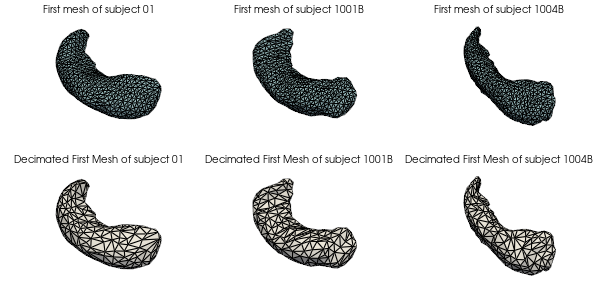

In [21]:
pl = pv.Plotter(shape=(2, 3), border=False, window_size=[600, 300])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(putils.get_first(rigidly_aligned_meshes[subject_id]), show_edges=True)
    pl.add_text(
        f"First mesh of subject {subject_id}", position="upper_edge", font_size=4
    )

    pl.subplot(1, i)
    pl.add_mesh(putils.get_first(meshes[subject_id]), show_edges=True, color="white")
    pl.add_text(
        f"Decimated First Mesh of subject {subject_id}",
        position="upper_edge",
        font_size=4,
    )

pl.show()

In [33]:
def _key2name(key):
    sub_id, session_id = key.split("/")
    return f"{_sub_id2name(sub_id)}/mesh_{session_id}"
    
meshes2files = (
    ppdict.UnnestDict(sep="/")
    + DictMeshWriter(dirname=MESHES_DIR, ext="vtk", key2name=_key2name)
    + ppdict.NestDict(sep="/")
)
# subject, session, filename
dataset = meshes2files(meshes)
dataset

{'01': {'1': PosixPath('results/regression_example/meshes/sub_01/mesh_1.vtk'),
  '2': PosixPath('results/regression_example/meshes/sub_01/mesh_2.vtk'),
  '3': PosixPath('results/regression_example/meshes/sub_01/mesh_3.vtk'),
  '4': PosixPath('results/regression_example/meshes/sub_01/mesh_4.vtk'),
  '5': PosixPath('results/regression_example/meshes/sub_01/mesh_5.vtk'),
  '6': PosixPath('results/regression_example/meshes/sub_01/mesh_6.vtk'),
  '7': PosixPath('results/regression_example/meshes/sub_01/mesh_7.vtk'),
  '8': PosixPath('results/regression_example/meshes/sub_01/mesh_8.vtk'),
  '9': PosixPath('results/regression_example/meshes/sub_01/mesh_9.vtk'),
  '10': PosixPath('results/regression_example/meshes/sub_01/mesh_10.vtk'),
  '11': PosixPath('results/regression_example/meshes/sub_01/mesh_11.vtk'),
  '12': PosixPath('results/regression_example/meshes/sub_01/mesh_12.vtk'),
  '13': PosixPath('results/regression_example/meshes/sub_01/mesh_13.vtk'),
  '14': PosixPath('results/regression

## Estimate deterministic atlas for subject and global

Compute subject specific deterministic atlas by averaging pre-pregnancy meshes.

First, we select the pre-pregnancy meshes.

In [29]:


pre_keys_selector = ppd.DfIsInFilter("stage", ["pre"]) + (lambda x: x.index) + Map(lambda x: str(x))

pre_keys = ppdict.DictMap(pre_keys_selector)(csvs)
pre_keys


{'01': ['1', '2', '3', '4', '5'],
 '1001B': ['base1', 'base2'],
 '1004B': ['base1']}

In [30]:


pre_dataset = {
    subject_id: ppdict.SelectKeySubset(pre_keys[subject_id])(meshes)
    for subject_id, meshes in dataset.items()
}


In [34]:
pre_dataset

{'01': {'1': PosixPath('results/regression_example/meshes/sub_01/mesh_1.vtk'),
  '2': PosixPath('results/regression_example/meshes/sub_01/mesh_2.vtk'),
  '3': PosixPath('results/regression_example/meshes/sub_01/mesh_3.vtk'),
  '4': PosixPath('results/regression_example/meshes/sub_01/mesh_4.vtk'),
  '5': PosixPath('results/regression_example/meshes/sub_01/mesh_5.vtk')},
 '1001B': {'base1': PosixPath('results/regression_example/meshes/sub_1001B/mesh_base1.vtk'),
  'base2': PosixPath('results/regression_example/meshes/sub_1001B/mesh_base2.vtk')},
 '1004B': {'base1': PosixPath('results/regression_example/meshes/sub_1004B/mesh_base1.vtk')}}

Closely follows [LDDMM: how to estimate a deterministic atlas?](./lddmm_deterministic_atlas.ipynb).

In [35]:
kernel_width = 10.0  # NB: influences the number of cp

registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    attachment_kernel_width=2.0,
    tol=1e-10,
)

In [37]:
templates = {}

for subject_id, dataset_ in pre_dataset.items():
    template = plddmm.learning.estimate_deterministic_atlas(
        source=putils.get_first(dataset_),
        targets=dataset_,
        output_dir=ATLAS_DIR / _sub_id2name(subject_id),
        initial_step_size=1e-1,
        **registration_kwargs,
    )

    templates[subject_id] = template


templates["global"] = plddmm.learning.estimate_deterministic_atlas(
    source=putils.get_first(templates),
    targets=templates,
    output_dir=ATLAS_DIR / "global",
    initial_step_size=1e-1,
    **registration_kwargs,
)

templates = ppdict.DictMap(PvReader())(templates)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS found in environment variables. Using value OMP_NUM_THREADS=128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/atlases/sub_01/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
{'max_iterations': 2000, 'freeze_template': False, 'freeze_control_points': False, 'freeze_momenta': False, 'use_sobolev_gradient': True, 'sobolev_kernel_width_ratio': 1, 'max_line_search_iterations': 50, 'initial_control_points': None, 'initial_cp_spacing': None, 'initial_momenta': None, 'dense_mode': False, 'number_of_threads': 1, 'print_every_n_iters': 20, 'downsampling_factor': 1, 'dimension': 3, 'optimization_method_type': 'ScipyLBFGS', 'con

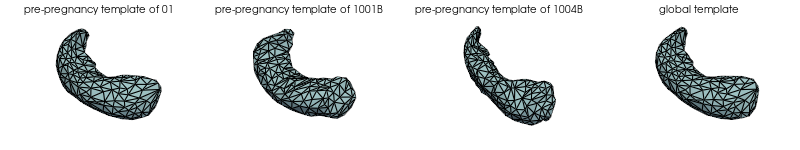

In [38]:
pl = pv.Plotter(shape=(1, 4), border=False, window_size=[800, 150])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(templates[subject_id], show_edges=True)
    pl.add_text(
        f"pre-pregnancy template of {subject_id}", position="upper_edge", font_size=4
    )

pl.subplot(0, 3)
pl.add_mesh(templates["global"], show_edges=True)
pl.add_text("global template", position="upper_edge", font_size=4)

pl.show()

In [42]:
for subject_id,meshes in dataset.items():
  source = plddmm.io.load_template(ATLAS_DIR / f'sub_{subject_id}', as_path=True)
  for mesh_id, mesh in meshes.items():
    target = mesh
    time_reg_dir = REGISTRATIONS_DIR / f'sub_{subject_id}' / f"time_reg_{mesh_id}"
    plddmm.registration.estimate_registration(
      source, target, output_dir=time_reg_dir, **registration_kwargs
    )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/registrations/sub_01/time_reg_1/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Gradient at Termination: 7781.886654687537
>> ABNORMAL: 
>> Estimation took: 01 seconds
Deformetrica.__del__()
Deformetrica.__del__()
Logger has been set to: DEBUG
>> No initial 

In [44]:
global_template = plddmm.io.load_template(ATLAS_DIR / 'global', as_path=True)

for subject_id,meshes in dataset.items():
  source = plddmm.io.load_template(ATLAS_DIR / f'sub_{subject_id}', as_path=True)
  output_dir = PARALLEL_GEOD_DIR / f'sub_{subject_id}'
  plddmm.registration.estimate_registration(
    source, global_template, output_dir=output_dir, **registration_kwargs
  )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 128
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/regression_example/parallel_geods/sub_01/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -1.829E+02 	 [ attachment = -1.706E+02 ; regularity = -1.234E+01 ]
>> Gradient a

In [48]:
for subject_id, meshes in dataset.items():
  parallel_geods_dir = PARALLEL_GEOD_DIR / f'sub_{subject_id}'
  control_points = plddmm.io.load_cp(parallel_geods_dir, as_path=True)
  momenta = plddmm.io.load_momenta(parallel_geods_dir, as_path=True)
  for mesh_id in meshes.keys():
    time_reg_dir = REGISTRATIONS_DIR / f'sub_{subject_id}' / f"time_reg_{mesh_id}"
    control_points_to_transport = plddmm.io.load_cp(time_reg_dir, as_path=True)
    momenta_to_transport = plddmm.io.load_momenta(time_reg_dir, as_path=True)
    transport_dir = TRANSPORTS_DIR / f'sub_{subject_id}' / f"time_reg_{mesh_id}"
    cp, mom = plddmm.geometry.pole_ladder(
      control_points,
      momenta,
      momenta_to_transport,
      transport_dir,
      control_points_to_transport=control_points_to_transport,
      kernel_width=kernel_width,
    )

In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow
In exponential update

/home/nmiolane/anaconda3/envs/polpo/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


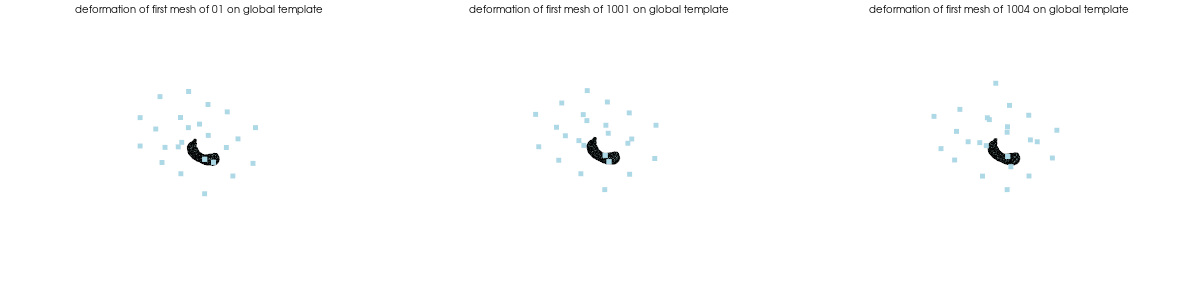

In [ ]:
# Check that control points are the same across subjects
pl = pv.Plotter(shape=(1, 3), border=False, window_size=[1200, 300])

for i, subject_id in enumerate(SUBJECT_IDS):
    pl.subplot(0, i)
    pl.add_mesh(templates["global"], show_edges=True)
    cps = pv.PolyData(control_points[subject_id][0].cpu().numpy())
    pl.add_mesh(cps)
    # Add arrows at control points showing momenta
    # cps["vectors"] = momenta[subject_id][0].cpu().numpy()
    # pl.add_mesh(cps.glyph(orient="vectors", scale=False, factor=2),
    #             color="red", opacity=0.8)
    pl.add_text(
        f"deformation of first mesh of {subject_id} on global template",
        position="upper_edge",
        font_size=4,
    )


pl.show()
# Check that momenta are the same across subjects

In [ ]:
from sklearn.linear_model import LinearRegression

X = []
y = []

for subject_id in SUBJECT_IDS:
    # Get pregnancy indices from CSV files
    subject_csv = csvs[subject_id]
    subject_momenta = momenta[subject_id]
    assert len(subject_momenta) == len(subject_csv)
    pregnancy_indices = subject_csv.reset_index().index[subject_csv["stage"] == "preg"]
    # Select corresponding pre-pregnancy meshes
    pregnancy_momenta = [subject_momenta[i] for i in pregnancy_indices]
    pregnancy_gestweek = subject_csv["gestWeek"][
        subject_csv["stage"] == "preg"
    ].tolist()
    assert len(pregnancy_gestweek) == len(pregnancy_momenta)
    print(f"Found {len(pregnancy_momenta)} pregnancy momenta")
    y.extend(pregnancy_gestweek)
    X.extend(pregnancy_momenta)


X = np.array(X).reshape(len(y), -1)
y = np.array(y)

# Standardize y to have zero mean and unit variance
y = (y - np.mean(y)) / np.std(y)


print(X.shape)
print(y.shape)

Found 7 pregnancy momenta
Found 14 pregnancy momenta
(21, 72)
(21,)


In [ ]:
# Train-test split and regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

regression = LinearRegression()
regression.fit(X_train, y_train)

train_r2 = regression.score(X_train, y_train)
test_r2 = regression.score(X_test, y_test)

print(f"Regression coefficients: {regression.coef_}")
print(f"Regression intercept: {regression.intercept_}")
print(f"Train R2 score: {train_r2:.3f}")
print(f"Test R2 score: {test_r2:.3f}")

Regression coefficients: [-0.0475128  -0.20793428  0.12518647 -0.40066458 -0.30088703  0.13057257
  0.11033436  0.17746964  0.16130291  0.37172321  0.04971518 -0.1947087
  0.00707097  0.04679694 -0.14465205 -0.06615254  0.02296597 -0.03906212
 -0.15404887 -0.09492599 -0.08598621 -0.20808952  0.1928069   0.20513928
  0.08681601  0.01675351 -0.04860588  0.05266796 -0.14478317  0.02885679
 -0.03100625  0.04538691 -0.10291122 -0.00315975 -0.10886183  0.15149466
  0.0970834  -0.0382668   0.08020802 -0.11975142  0.10791238 -0.13274261
  0.02983922 -0.14670629  0.0763163   0.11544306  0.00725577 -0.02045337
  0.09999708 -0.0052859   0.12839739 -0.02726886  0.07361428 -0.146344
  0.12439884 -0.17373766 -0.12048952  0.18532592 -0.20879205 -0.03906035
 -0.13822599  0.16314038 -0.00389031  0.09263556 -0.0472091   0.04504123
 -0.04774953  0.03857911  0.09940681 -0.03347729 -0.11363047 -0.09416703]
Regression intercept: 0.5789366094388145
Train R2 score: 1.000
Test R2 score: -1.999
